# A simple benchmark example

In [48]:
from plumed_bench_pp.parser import parse_full_benchmark_output
from plumed_bench_pp.tabulate import convert_to_table
from plumed_bench_pp.plot import plot_histo
import plumed_bench_pp.constants as plmdbppconst
import plumed_bench_pp.utils as plmdbpputils
import matplotlib.pyplot as plt
import numpy as np
nthreads=[1,2,4,6,8,10,12]

The benchmark are run with the following plumed.dat file:

```plumed
cpu: COORDINATION GROUPA=@mdatoms R_0=1

PRINT ARG=* FILE=Colvar FMT=%8.4f STRIDE=1

FLUSH STRIDE=1

```

and we use the following script for the running the benchmark:
```bash
export PLUMED_MAXBACKUP=0
for nt in 1 2 4 6 8 10 12; do
    export PLUMED_NUM_THREADS=$nt
    for nat in 100 500 1000; do
        plumed benchmark --nsteps=500 --natoms=$nat --atom-distribution=sc > "./run/sc_${nt}_${nat}.out"
    done
done
```

Text(0, 0.5, 'time (s)')

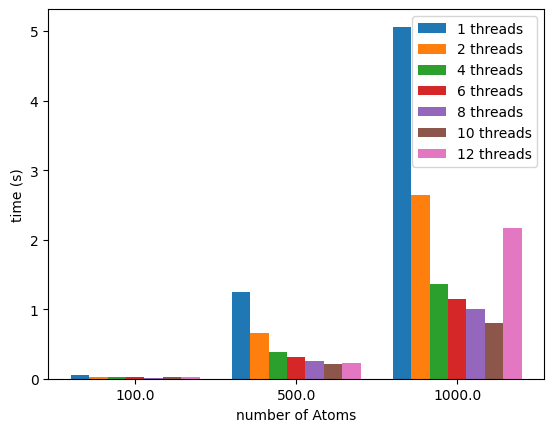

In [62]:
#bash script to prepare the data to be plotted
!for threads in 1 2 4 6 8 10 12; do \
    { for natoms in 100 500 1000; do \
        echo -n "$natoms ";\
        fname="./run/sc_${threads}_${natoms}.out";\
        sed -n '/PLUMED: *Cycles *Total *Average *Minimum *Maximum/{n ; p}' "${fname}" | \
        awk '{printf "%f ", $3}';\
        echo "";\
        done;\
    } > "./run/times_${threads}.out";\
done

simPerThread={}
for threads in nthreads:
    simPerThread[threads]=np.loadtxt(f"./run/times_{threads}.out")
fig,ax =plt.subplots()

ncols = len(simPerThread)
x = simPerThread[nthreads[0]][:,0]
x_coord=np.arange(len(x))
width = 0.8/ncols
ax.set_xticks(x_coord + width * 0.5 * (ncols - 1), x)

for multiplier, nt in enumerate(nthreads):
    offset = width * multiplier

    toplot = simPerThread[nt][:,1]
    ax.bar(
            x_coord + offset,
            toplot,
            width,
            label=f"{nt} threads",
        )
       
ax.legend()
ax.set_xlabel("number of Atoms")
ax.set_ylabel("time (s)")

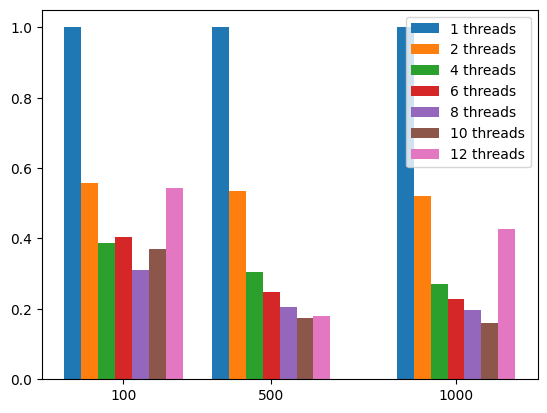

In [54]:
benchmarks={}

for threads in nthreads:
    benchmarks[threads]=[]
    for atoms in [100, 500, 1000]:
        with open(f"./run/sc_{threads}_{atoms}.out") as f:
            benchmarks[threads].append(parse_full_benchmark_output(f.readlines()))

t=[]
for threads in nthreads:
    t.append(convert_to_table(benchmarks[threads],kernel="this",inputlist=".dat",rows_to_extract=[plmdbppconst.TOTALTIME]))
fig,ax =plt.subplots()
plot_histo(ax,t,plmdbppconst.TOTALTIME, titles=[f"{threads} threads" for threads in nthreads],relative_to=0)
ax.legend()